In [1]:
pip install aif360


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cvxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 590.3 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
#import sys
#sys.path.append(r'C:\Users\festa\OneDrive\Desktop\Thesis\Thesis')
from functions import load_and_process_data, apply_bias_mitigation, evaluate_fairness_metrics, standardize_features, train_classifier_and_find_best_threshold, apply_best_threshold_and_compute_metrics, plot_metrics_dir, plot_metrics_aod, train_classifier_on_transformed_data, extract_fairness_metrics
from functions import aif360_to_clearbox, filter_dataset, generate_multiple_synthetic_datasets
from clearbox_engine import Dataset, Preprocessor, TabularEngine, LabeledSynthesizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import pandas as pd
from aif360.datasets import BinaryLabelDataset

# Ensure reproducibility
np.random.seed(1)

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [69]:
train, val, test, privileged_groups, unprivileged_groups = load_and_process_data('meps', use_disparate_impact_remover=False)


In [70]:
train_dataset = aif360_to_clearbox(train, target_column="UTILIZATION")
test_dataset = aif360_to_clearbox(test, target_column="UTILIZATION")
val_dataset = aif360_to_clearbox(val, target_column="UTILIZATION")

In [71]:
# Apply filtering to both train and test datasets
train_filtered_dataset, df = filter_dataset(train_dataset, "positive_race", "UTILIZATION")
test_filtered_dataset, df_test = filter_dataset(test_dataset, "positive_race", "UTILIZATION")

In [81]:
# Number of synthetic datasets to generate
num_datasets = 1
extra_percentage = 0.5  # generate 50% of an additional dataset
half = True  # enable generating partial dataset



train_synthetic_combined_df = generate_multiple_synthetic_datasets(
    df,
    target_column="UTILIZATION",
    engine_class=TabularEngine,
    num_datasets=num_datasets,
    half=half,
    extra_percentage=extra_percentage
)

test_synthetic_combined_df = generate_multiple_synthetic_datasets(
    df_test,
    target_column="UTILIZATION",
    engine_class=TabularEngine,
    num_datasets=num_datasets,
    half=half,
    extra_percentage=extra_percentage
)



/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (908). n_quantiles is set to n_samples.
  warnings.warn(
2025-03-22 13:12:25.160 | INFO     | functions:generate_multiple_synthetic_datasets:849 - I'm the Sept 2024 engine!


Clearbox AI Engine: your license is valid.
Training Tabular Engine...


Engine fitting in progress: 100%|██████████| 5/5 [00:01<00:00,  4.49epoch/s, Train loss:=270533570.0]
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (908). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
2025-03-22 13:12:26.683 | INFO     | functions:generate_multiple_synthetic_datasets:849 - I'm the Sept 2024 engine!


Generating an extra partial synthetic dataset of size: 454
Clearbox AI Engine: your license is valid.
Training Tabular Engine...


Engine fitting in progress: 100%|██████████| 5/5 [00:01<00:00,  4.41epoch/s, Train loss:=352488220.0]
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(


Generating an extra partial synthetic dataset of size: 87


In [82]:
# Concatenate original and synthetic datasets
final_train_dataset = pd.concat([train_dataset.data, train_synthetic_combined_df], axis=0, ignore_index=True)
final_test_dataset = pd.concat([test_dataset.data, test_synthetic_combined_df], axis=0, ignore_index=True)

# Print shapes and column information
print("Final Train Dataset Shape:", final_train_dataset.shape)
print("Final Test Dataset Shape:", final_test_dataset.shape)

Final Train Dataset Shape: (12443, 21)
Final Test Dataset Shape: (2636, 21)


In [83]:
train_0 = train_dataset.data
train_transf_0 = final_train_dataset
test_0 = test_dataset.data
test_transf_0 = final_test_dataset
val_0 = val_dataset.data


In [91]:
# Update the protected attribute to use the correct column
protected_attributes = ['RACE']

# Convert processed datasets to BinaryLabelDataset
train = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=train_0,
    label_names=["UTILIZATION"],  # Target column
    protected_attribute_names=protected_attributes
)

test = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=test_0,
    label_names=["UTILIZATION"],  # Target column
    protected_attribute_names=protected_attributes
)


# Evaluate fairness metrics
privileged_groups = [{'RACE': 1}]  
unprivileged_groups = [{'RACE': 0}]  

In [92]:
# Convert transformed datasets to BinaryLabelDataset
train_transf = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=train_transf_0,
    label_names=["UTILIZATION"],  # Target column
    protected_attribute_names=protected_attributes # Use 'sex' as it is not one-hot encoded
)

test_transf = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=test_transf_0,
    label_names=["UTILIZATION"],  # Target column
    protected_attribute_names=protected_attributes  # Use 'sex' as it is not one-hot encoded
)

# Convert validation dataset to BinaryLabelDataset
val = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=val_0,
    label_names=["UTILIZATION"],  # Target column
    protected_attribute_names=protected_attributes  # Use 'sex' as it is not one-hot encoded
)



In [93]:
train_before_stat_parity_diff, train_before_disp_impact = evaluate_fairness_metrics(train, unprivileged_groups, privileged_groups, "Train Dataset (Before Transformation)")
test_before_stat_parity_diff, test_before_disp_impact = evaluate_fairness_metrics(test, unprivileged_groups, privileged_groups, "Test Dataset (Before Transformation)")

train_after_stat_parity_diff, train_after_disp_impact = evaluate_fairness_metrics(train_transf, unprivileged_groups, privileged_groups, "Train Dataset (After Transformation)")
test_after_stat_parity_diff, test_after_disp_impact = evaluate_fairness_metrics(test_transf, unprivileged_groups, privileged_groups, "Test Dataset (After Transformation)")

print("Train Dataset (Before Transformation) - Statistical Parity Difference:", train_before_stat_parity_diff)
print("Train Dataset (Before Transformation) - Disparate Impact:", train_before_disp_impact)
print("Test Dataset (Before Transformation) - Statistical Parity Difference:", test_before_stat_parity_diff)
print("Test Dataset (Before Transformation) - Disparate Impact:", test_before_disp_impact)

print("Train Dataset (After Transformation) - Statistical Parity Difference:", train_after_stat_parity_diff)
print("Train Dataset (After Transformation) - Disparate Impact:", train_after_disp_impact)
print("Test Dataset (After Transformation) - Statistical Parity Difference:", test_after_stat_parity_diff)
print("Test Dataset (After Transformation) - Disparate Impact:", test_after_disp_impact)

Train Dataset (Before Transformation) - Statistical Parity Difference: -0.1264
Train Dataset (Before Transformation) - Disparate Impact: 0.5029
Test Dataset (Before Transformation) - Statistical Parity Difference: -0.1491
Test Dataset (Before Transformation) - Disparate Impact: 0.4347
Train Dataset (After Transformation) - Statistical Parity Difference: 0.0140
Train Dataset (After Transformation) - Disparate Impact: 1.0549
Test Dataset (After Transformation) - Statistical Parity Difference: -0.0192
Test Dataset (After Transformation) - Disparate Impact: 0.9272


In [94]:
# Standardize the features (scaling)
train, val, test = standardize_features(train, val, test)

# Choose classifier type
classifier_type = 'random_forest'  # Change to 'random_forest' or 'xgboost'

# Train classifier
classifier, best_threshold, best_balanced_acc = train_classifier_and_find_best_threshold(train, val, classifier_type, unprivileged_groups, privileged_groups)

Best Threshold: 0.18000000000000002
Best Balanced Accuracy: 0.7215607389172584


In [95]:
test_metrics, test_scores = apply_best_threshold_and_compute_metrics(classifier, test, best_threshold, unprivileged_groups, privileged_groups)


Balanced Accuracy (test): 0.7232753164556962
Statistical Parity Difference (test): -0.2361218086193988
Disparate Impact (test): 0.48899901518478595
Average Odds Difference (test): -0.16600275723658975
Equal Opportunity Difference (test): -0.15008646119418168
Theil Index (test): 0.10460378479974483


In [96]:
%matplotlib inline


/usr/local/lib/python3.9/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


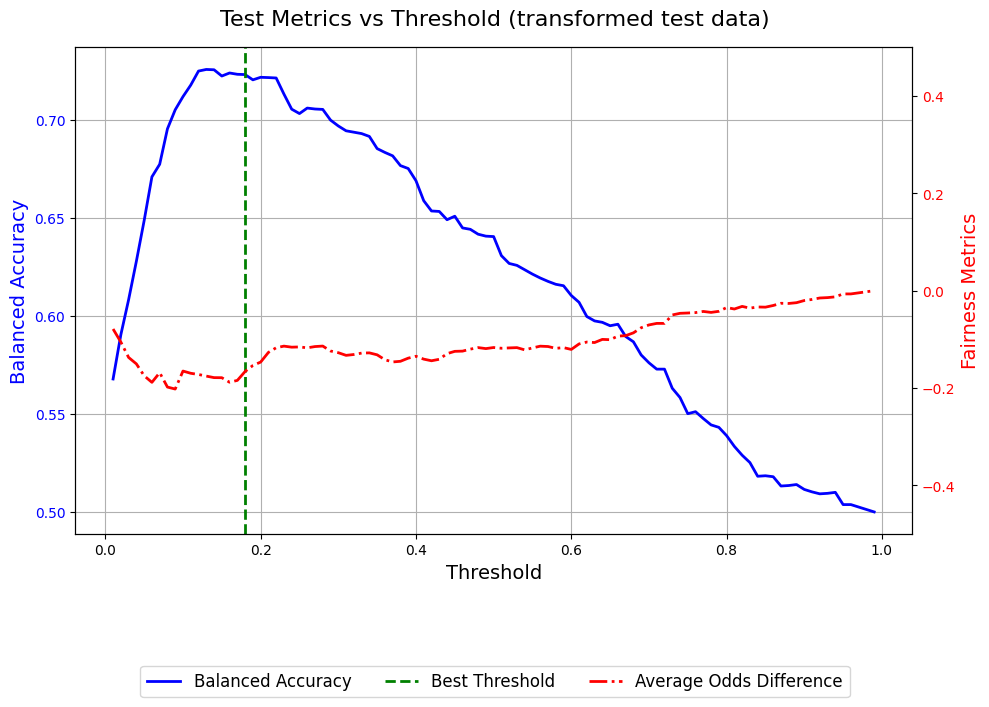

In [97]:
plot_metrics_aod(test, test_scores, best_threshold, unprivileged_groups, privileged_groups)


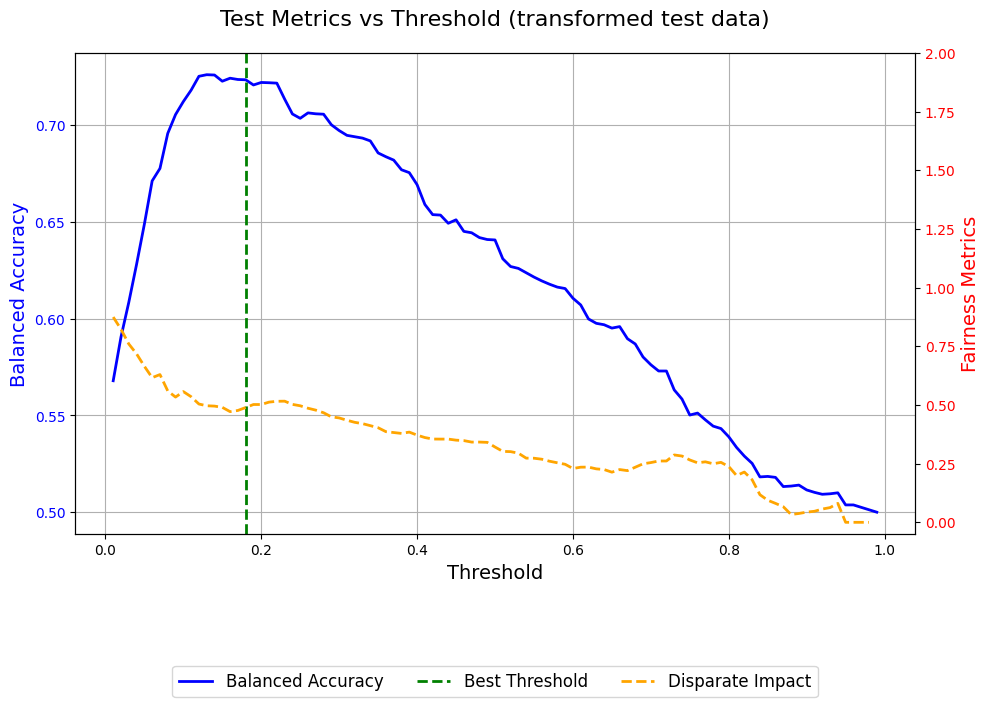

In [98]:
plot_metrics_dir(test, test_scores, best_threshold, unprivileged_groups, privileged_groups)


In [99]:
# Standardize the features (scaling)
train_transf, _ , test_transf = standardize_features(train_transf, val, test_transf)

# Train classifier on transformed data and use the same threshold
classifier_type = 'random_forest'  # Change to 'random_forest' or 'xgboost'
test_transf_classifier, test_transf_scores, test_transf_metrics = train_classifier_on_transformed_data(
    train_transf, test_transf, classifier_type, best_threshold, unprivileged_groups, privileged_groups)

Balanced Accuracy (test transformed): 0.7839395622283076
Statistical Parity Difference (test transformed): -0.10699965827169433
Disparate Impact (test transformed): 0.7630524363337415
Average Odds Difference (test transformed): -0.025401164334543827
Equal Opportunity Difference (test transformed): 0.12031329468009355
Theil Index (test transformed): 0.09709782503900692


In [100]:
#(0.89,0.69), 0.67, 0.68, 0.69, 0.68, (0.81,0.70) 

In [101]:
%matplotlib inline


/usr/local/lib/python3.9/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


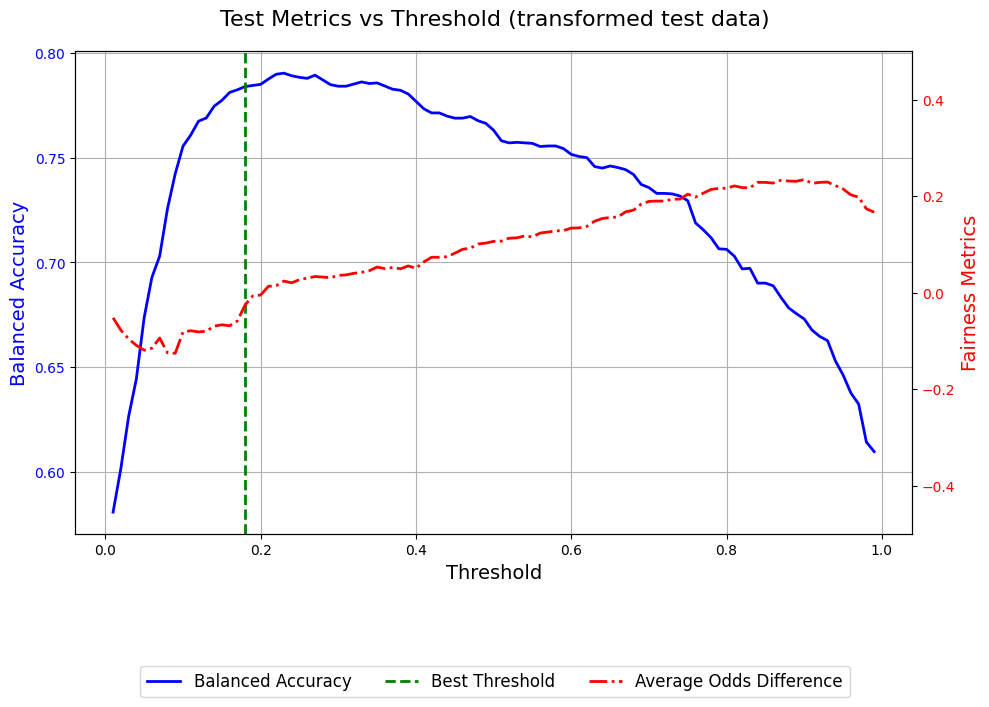

In [102]:
plot_metrics_aod(test_transf, test_transf_scores, best_threshold, unprivileged_groups, privileged_groups)


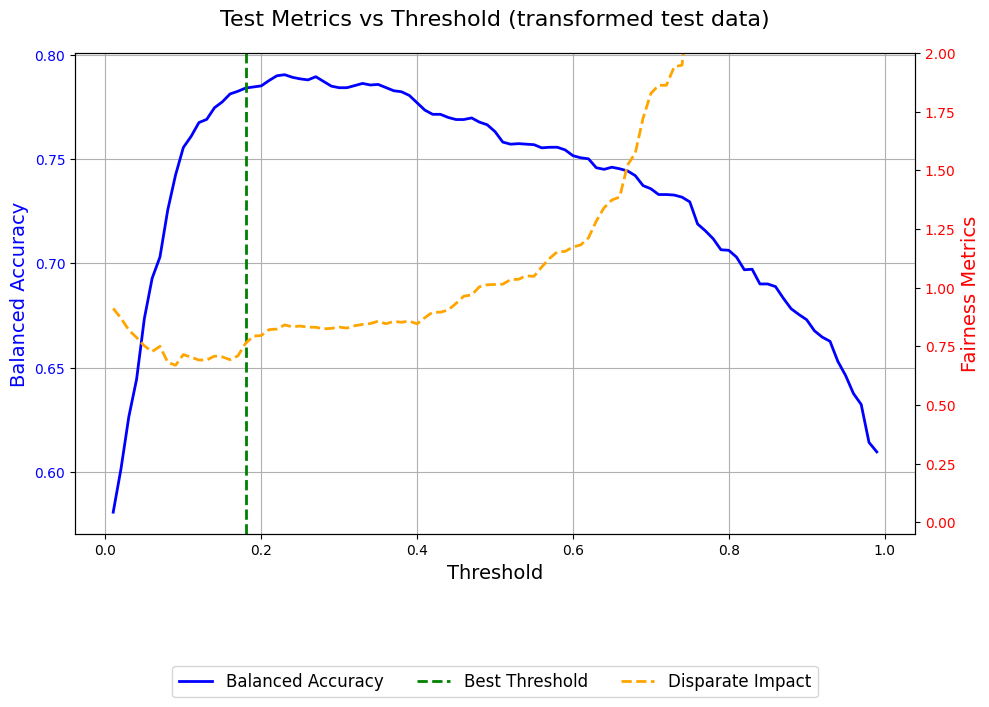

In [103]:
plot_metrics_dir(test_transf, test_transf_scores, best_threshold, unprivileged_groups, privileged_groups)


In [104]:
fairness_metrics, validation_metrics, test_metrics = extract_fairness_metrics(
    train_before_stat_parity_diff, train_after_stat_parity_diff,
    test_before_stat_parity_diff, test_after_stat_parity_diff,
    train_before_disp_impact, train_after_disp_impact,
    test_before_disp_impact, test_after_disp_impact,
    best_threshold, best_balanced_acc,
    test_metrics, test_transf_metrics
)

# Displaying the tables
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)

'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.1264
1,Train,After Transformation,Statistical Parity Difference,0.0140
2,Test,Before Transformation,Statistical Parity Difference,-0.1491
3,Test,After Transformation,Statistical Parity Difference,-0.0192
4,Train,Before Transformation,Disparate Impact,0.5029
5,Train,After Transformation,Disparate Impact,1.0549
6,Test,Before Transformation,Disparate Impact,0.4347
7,Test,After Transformation,Disparate Impact,0.9272


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.180000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.721561


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.723275
1,Test (Transformed),After Threshold,Balanced Accuracy,0.783940
2,Test (Original),After Threshold,Statistical Parity Difference,-0.236122
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.107000
4,Test (Original),After Threshold,Disparate Impact,0.488999
5,Test (Transformed),After Threshold,Disparate Impact,0.763052
6,Test (Original),After Threshold,Average Odds Difference,-0.166003
7,Test (Transformed),After Threshold,Average Odds Difference,-0.025401
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.150086
9,Test (Transformed),After Threshold,Equal Opportunity Difference,0.120313
